<a href="https://colab.research.google.com/github/MuhammadAhtishamYousaf/LangGraph/blob/main/Lec_3_Routing_in_langgraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --quiet -U langchain_google_genai langchain_core langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.0/413.0 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 2.5 MB/s eta 0:00:00


In [ ]:
from google.colab import userdata
GEMINI_API_KEY=userdata.get('GEMINI_API_KEY')

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI as genai

def multiply_values(a: int, b: int) -> int:
    """Multiply two values
    Args:
    a: first int
    b: second int
    Returns:
    a * b
    """
    return a * b


In [ ]:
llm=genai(model='gemini-1.5-flash',api_key=GEMINI_API_KEY)


In [ ]:
llm_with_tool_bind=llm.bind_tools([multiply_values])

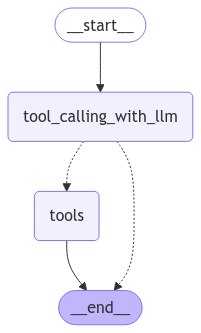

In [ ]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START,END
from langgraph.graph import MessagesState # Make sure MessagesState is imported correctly
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.graph.state import CompiledStateGraph

#node function

def tool_calling_with_llm(state: MessagesState): # Specify the type of the argument
    # Access the messages using state['messages']
    return {"messages":llm_with_tool_bind.invoke(state['messages'])}

#build graph
builder:StateGraph=StateGraph(MessagesState)
builder.add_node("tool_calling_with_llm",tool_calling_with_llm)
builder.add_node("tools",ToolNode([multiply_values]))

#Edges
builder.add_edge(START,"tool_calling_with_llm")
builder.add_conditional_edges(
    "tool_calling_with_llm",
    #if the llm response is a tool call -> tools condition will be towards tools
    #if the llm response is natural language, tools condition will be towards end
    tools_condition
)

builder.add_edge("tools",END)

graph: CompiledStateGraph=builder.compile()

# display
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
from langchain_core.messages import HumanMessage, SystemMessage
messages = [SystemMessage(content="You are a helpfull assistant.") , HumanMessage(content="Multiply 5 with 5")]
messages = graph.invoke({"messages": messages})
print(messages)
for m in messages['messages']:
    m.pretty_print()

{'messages': [SystemMessage(content='You are a helpfull assistant.', additional_kwargs={}, response_metadata={}, id='4c23205a-b1c8-4d0b-ade5-ebcab570da3c'), HumanMessage(content='Multiply 5 with 5', additional_kwargs={}, response_metadata={}, id='37bba590-54a7-441a-a391-d20edf633c62'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply_values', 'arguments': '{"a": 5.0, "b": 5.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-802a6e1c-26f5-4ef8-a183-795df9437297-0', tool_calls=[{'name': 'multiply_values', 'args': {'a': 5.0, 'b': 5.0}, 'id': 'd457766c-9dd1-4e30-8ef9-2367a7c325a1', 'type': 'tool_call'}], usage_metadata={'input_tokens': 43, 'output_tokens': 5, 'total_tokens': 48, 'input_token_details': {'cache_read': 0}}), ToolMessage(content='25', name='multiply_values', id='0014a177-635e-4a32-8575-1eb10d8972c4', tool_call_id='d457766c-9dd1-4e30-8ef9-2367a7c325a1')]}
===